# Klassifikation
Da mir lediglich Laptop-Lautsprecher und Laptop-Mikrofon zur verfügung stehen lassen sich leider keine gerichteten Audiosignale erzeugen und aufnehmen. Eine Objekterkennung wird daher vermutlich schwierig. 
Im folgenden versuche ich daher erst einmal das Echo in verschiedenen Räumen einzufangen und mit einem einfachen CNN zu erkennen in welchen Raum das Echo eingefangen wurde.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import pathlib
import numpy as np
import glob
import os
import tensorflow_io as tfio
from components.signal_generator import signal_generator,audio_interface 

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Daten-Pipeline erstellen

In [44]:
#CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"])
CLASS_NAMES=["toilet","livingroom","bathroom"]
BATCH_SIZE = 32

def label_encoder(label):
    temp=[0]*len(CLASS_NAMES)
    for i,x in enumerate(CLASS_NAMES):
        if x==label:
            temp[i]=1
    return temp

def label_decoder(label):
    l=""
    for i,x in enumerate(label): 
        if x==1:
            l=CLASS_NAMES[i]
    return l
def process_path(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    spec={"/signal":tf.float64,"/rir":tf.float64}
    samples = tfio.v0.IOTensor.from_hdf5(file_path,spec=spec)("/rir").to_tensor()[:50000] #TODO
    
    return tf.reshape(samples,[50000,1]), label_encoder(label)

def prepare_for_training(ds,batch_size, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def make_dataset(path,batch_size):
    data_dir = pathlib.Path(path)
    list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
    labeled_ds = list_ds.map(process_path,num_parallel_calls=AUTOTUNE)
    print(path,len(list_ds),"files")
    return prepare_for_training(labeled_ds,batch_size=batch_size)

train_dataset = make_dataset("../data/split/train/",batch_size=BATCH_SIZE)
val_dataset = make_dataset("../data/split/val/",batch_size=1)
test_dataset = make_dataset("../data/split/test/",batch_size=1)

#train_dataset = prepare_for_training(labeled_ds.take(int(len(list_ds)*0.6)))
#test_dataset = prepare_for_training(labeled_ds.skip(int(len(list_ds)*0.6)))

../data/split/train/ 2285 files
../data/split/val/ 574 files
../data/split/test/ 717 files


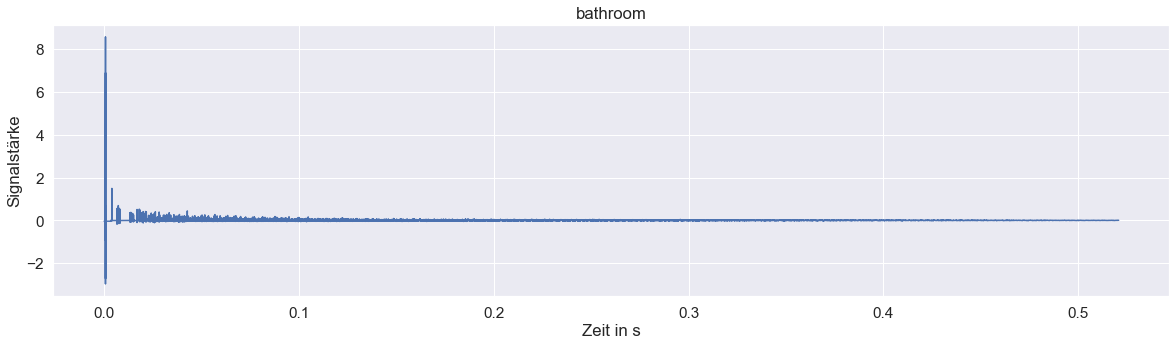

In [45]:
for image_raw, label_text in val_dataset.take(1):
    signal_generator(sr=96000).plot_signal(image_raw.numpy().reshape(50000),title=label_decoder(label_text[0]))

In [46]:
for image, label in val_dataset.take(1):
    print(image.shape)
    #print("Image shape: ", image.numpy().shape)
    #print("Label: ", label.numpy())
    print("Label: ", label.numpy())


(1, 50000, 1)
Label:  [[0 1 0]]


## CNN-Architektur erstellen

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Dropout
from tensorflow.keras import regularizers

model = Sequential([
    Conv1D(8, 3, padding='same', activation='relu', input_shape=(50000,1),name="inputlayer"),
    MaxPooling1D(),
    Conv1D(16, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Conv1D(32, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Conv1D(64, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Conv1D(128, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Conv1D(256, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    #Dropout(0.2),
    Conv1D(128, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Dropout(0.3),
    Conv1D(64, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Conv1D(32, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(l=0.1)),
    Dropout(0.3),
    Dense(3, activation='softmax', name='output')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer (Conv1D)          (None, 50000, 8)          32        
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 25000, 8)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 25000, 16)         400       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 12500, 16)         0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 12500, 32)         1568      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 6250, 32)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 6250, 64)         

In [48]:
model.compile(
        optimizer='adam',
        loss=['categorical_crossentropy'],
        metrics=['accuracy']
    )

In [49]:
history=model.fit(train_dataset,epochs=5,validation_data=val_dataset,steps_per_epoch=30,validation_steps=10)

Epoch 1/5
30/30 [==============================] - 108s 4s/step - loss: 18.8491 - accuracy: 0.6073 - val_loss: 2.7144 - val_accuracy: 1.0000
Epoch 2/5
30/30 [==============================] - 83s 3s/step - loss: 0.9332 - accuracy: 0.9573 - val_loss: 0.2338 - val_accuracy: 1.0000
Epoch 3/5
30/30 [==============================] - 84s 3s/step - loss: 0.2493 - accuracy: 0.9823 - val_loss: 0.1523 - val_accuracy: 1.0000
Epoch 4/5
30/30 [==============================] - 85s 3s/step - loss: 0.1802 - accuracy: 0.9875 - val_loss: 0.1079 - val_accuracy: 1.0000
Epoch 5/5
30/30 [==============================] - 83s 3s/step - loss: 0.1100 - accuracy: 0.9948 - val_loss: 0.0840 - val_accuracy: 1.0000


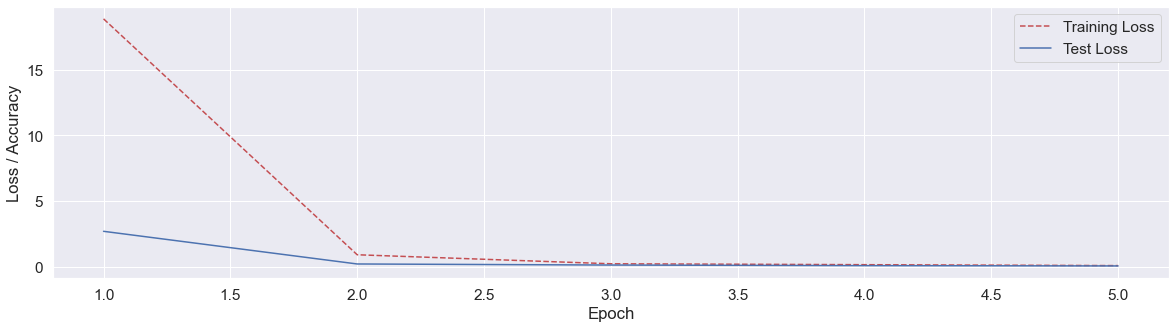

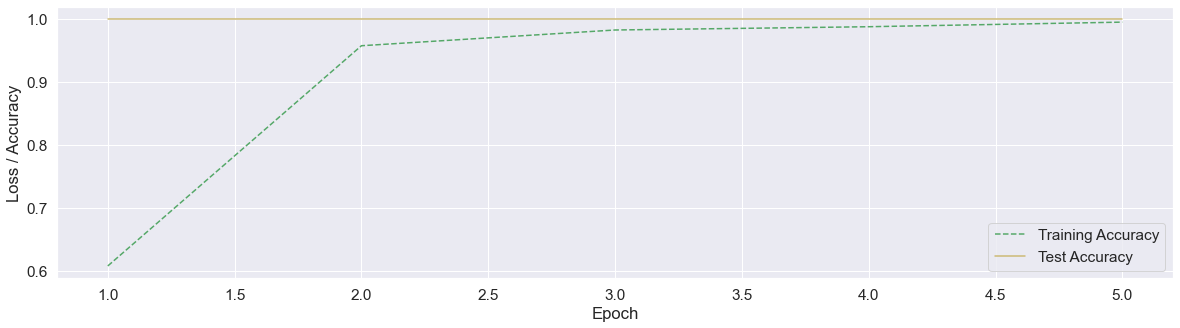

In [50]:

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)


# Visualize loss history
plt.figure(figsize=(20,5))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss','training_accuracy','test_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.show();

plt.figure(figsize=(20,5))
plt.plot(epoch_count, training_accuracy, 'g--')
plt.plot(epoch_count, test_accuracy, 'y-')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.show();

In [97]:
true=[]
pred=[]
for images, labels in test_dataset.take(500):
    for index,image in enumerate(images):
        pred_temp=model.predict(tf.reshape(image,(1,50000,1)))[0]
        pred_temp=[1 if x ==max(pred_temp) else 0 for x in pred_temp]
        true_temp=(labels[index].numpy())
        true.append(np.argmax(true_temp))
        pred.append(np.argmax(pred_temp))


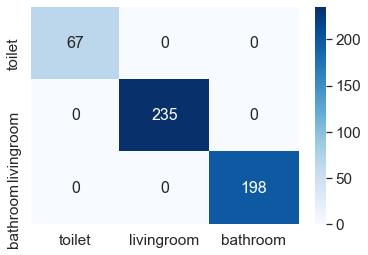

In [98]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(tf.math.confusion_matrix(true,pred).numpy(), CLASS_NAMES, CLASS_NAMES)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap="Blues",fmt="d") # font size

plt.show()

## Live Testing

toilet


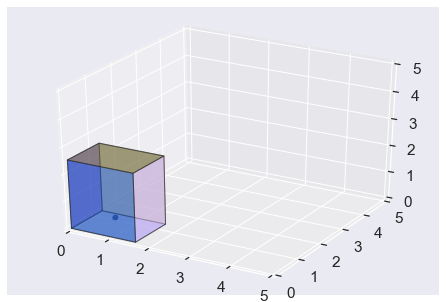

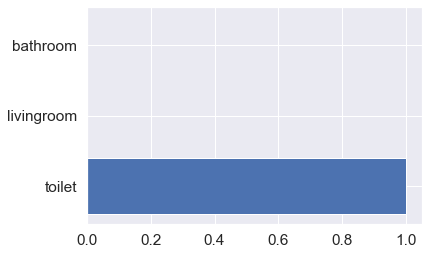

In [96]:
from components.room_simulator import room_simulator as rs
from components.signal_generator import signal_generator
room=rs(N_mutations_per_roomtype=1,roomtype="toilet").rooms[0]
f,ax=room.plot()
ax.set_xlim([0,5])
ax.set_ylim([0,5])
ax.set_zlim([0,5])
#plt.show()

room.compute_rir()
pred_temp_raw=model.predict(tf.reshape(room.rir[0][0][:50000],(1,50000,1)))[0]
pred_temp=[1 if x ==max(pred_temp_raw) else 0 for x in pred_temp_raw]

print(label_decoder(pred_temp))

fig, axs = plt.subplots()
axs.barh([0,1,2],pred_temp_raw, align='center')
axs.set_yticks([0,1,2])
axs.set_yticklabels(CLASS_NAMES)
plt.show()
